# Your first mechanics solver- linear elasticity analysis

- [x] stress/strain
- [x] constitutive law
- [x] projection
- [x] loading
- [x] 1d/2d stress equilibirium equation

Author: Yang Bai @ M3 Group

Date  : 2022.01.29

QQ group: 628204857

## Stress and strain

In this notebook, we focus on the small strain deformation, where the strain can
be defined as follows:
$$\mathbf{\varepsilon}=\frac{1}{2}(\nabla u+\nabla^{T}u)$$
or 
$$\varepsilon_{ij}=\frac{1}{2}(u_{i,j}+u_{j,i})$$

Accordingly, the stress can be read as follows:
$$\mathbf{\sigma}=\mathbb{C}:\mathbf{\varepsilon}$$
or
$$\sigma_{ij}=\mathbb{C}_{ijkl}\varepsilon_{kl}$$

## Constitutive laws

For the linear elasticity problem, one can have the following constitutive law:
$$\mathbb{C}_{ijkl}=\lambda\delta_{ij}\delta_{kl}+\mu(\delta_{ik}\delta_{jl}+\delta_{il}\delta_{jk})$$
with $\lambda=K-\frac{2}{3}\mu$ and $\mu$ being the lame constant and shear modulus, respectively. $K$ is the bulk modulus. One can also calculate $K$ and $\mu$ by using the Youngs modulus $E$ and poisson ratio $\nu$ as follows:
$$K=\frac{E}{3(1-\nu)},\mu=\frac{E}{2(1+\nu)}$$
Then the stress can be given as follows:
$$\sigma=\mathbb{C}:\mathbf{\varepsilon}=\lambda\mathrm{tr}(\mathbf{\varepsilon})\mathbf{I}+2\mu\mathbf{\varepsilon}=\frac{E\nu}{(1+\nu)(1-2\nu)}\mathrm{tr}(\mathbf{\varepsilon})\mathbf{I}+\frac{E}{1+\nu}\mathbf{\varepsilon}$$

### Voigt notation
By introducing the voigt notation, we can simplify the complex rank-4 tensor $\mathbb{C}$ to the following expression:
$$\mathbb{C}=\begin{bmatrix}
C_{11} & C_{12} & C_{12} & 0 & 0 & 0 \\
C_{12} & C_{11} & C_{12} & 0 & 0 & 0 \\
C_{12} & C_{12} & C_{11} & 0 & 0 & 0 \\
     0 &      0 &      0 & C_{44} & 0 & 0 \\
     0 &      0 &      0 &      0 & C_{44} & 0 \\
     0 &      0 &      0 &      0 &      0 & C_{44}
\end{bmatrix}
$$
where $C_{11}=\lambda+\mu$, $C_{12}=\lambda$, $C_{44}=\mu$.

### Plane stress
For plane stress case, one can have $\sigma_{zz}=0$, then the "3rd" strain should be given as $\varepsilon_{zz}=-\frac{\lambda}{\lambda+2\mu}(\varepsilon_{xx}+\varepsilon_{yy})$. The the new 'lame' constant can be defined as: $\lambda^{*}=2\frac{\lambda\mu}{\lambda+2\mu}$, and the correct stress can be read as: $\sigma=\lambda^{*}\mathrm{tr}(\mathbf{\varepsilon})\mathbf{I}+2\mu\mathbf{\varepsilon}$.

# Linear elasticity in 1D case

$$\nabla\sigma_{x}=\nabla(E\varepsilon_{x})=E\frac{\partial^{2}u_{x}}{\partial x^{2}}=0,\quad\mathrm{with}~u=u_{g}~\mathrm{on}~\Omega_{D},~\sigma_{x}=t_{x}~\mathrm{on}~\Omega_{N}$$

The right hand side and jacobian are:
$K=\int_{\Omega}E\nabla N^{J}\nabla N^{I}dV$ and $F_{int}=\int_{\Omega}\sigma_{x}N^{I}_{,x}dV$

In [1]:
# import the necessary modulues
from FEToy.mesh.lagrange1dmesh import mesh1d
from FEToy.fe.gaussrule import gausspoint1d
from FEToy.fe.shapefun import shape1d
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# define you physical parameters
L=1.0    # length of 1d domain
E=1.0e9  # Youngs modulus
ug=0.05   # preset displacement
nElmts=5

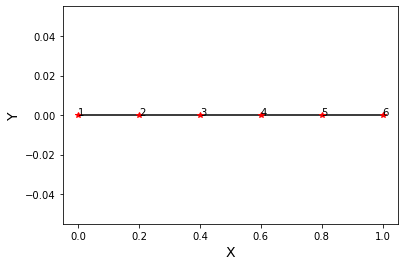

In [3]:
mymesh=mesh1d(xmin=0.0,xmax=L,nx=nElmts,meshtype='edge2')
mymesh.createmesh()
mymesh.plotmesh(withnode=True,withnodeid=True)

gpoints=gausspoint1d(ngp=2)
gpoints.creategausspoint()

shp=shape1d(meshtype='edge2')

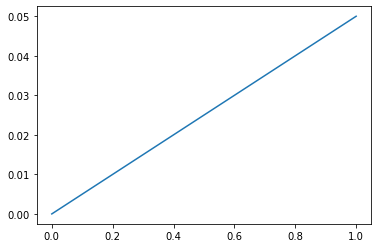

In [4]:
nDofs=mymesh.nodes*1 # total dofs
K=np.zeros((nDofs,nDofs))
F=np.zeros(nDofs)
# element loop
for e in range(mymesh.elements):
    elconn=mymesh.elementconn[e,:]
    nodes=mymesh.nodecoords[elconn]
    for gp in range(gpoints.ngp):
        xi=gpoints.gpcoords[gp,1]
        w =gpoints.gpcoords[gp,0]
        shp_val,shp_grad,j=shp.calc(xi,nodes)
        JxW=j*w
        for i in range(mymesh.nodesperelement):
            iInd=elconn[i]
            for j in range(mymesh.nodesperelement):
                jInd=elconn[j]
                K[iInd,jInd]+=E*shp_grad[j]*shp_grad[i]*JxW
#############################################
### Apply boundary condition
#############################################
Penalty=1.0e20
iInd=mymesh.bcnodeids['left']
K[iInd,iInd]+=Penalty
F[iInd]+=0.0*Penalty

iInd=mymesh.bcnodeids['right']
K[iInd,iInd]+=Penalty
F[iInd]+=ug*Penalty

u=np.linalg.solve(K,F)

plt.plot(mymesh.nodecoords,u)

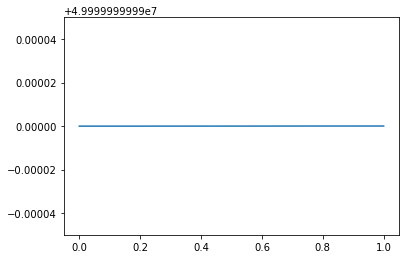

In [5]:
# Now we project the stress from gauss points to nodal points
Stress=np.zeros(nDofs)
for e in range(mymesh.elements):
    elconn=mymesh.elementconn[e,:]
    nodes=mymesh.nodecoords[elconn]
    elu=u[elconn]
    stress=0.0
    for gp in range(gpoints.ngp):
        xi=gpoints.gpcoords[gp,1]
        w =gpoints.gpcoords[gp,0]
        shp_val,shp_grad,j=shp.calc(xi,nodes)
        JxW=j*w
        strain=0.0
        for i in range(mymesh.nodesperelement):
            strain+=shp_grad[i]*elu[i] # dux/dx=sum_{i}dNi/dx*uix
        stress+=E*strain*(1.0/gpoints.ngp) # averaged stress
    # assemble to global
    for i in range(mymesh.nodesperelement):
        iInd=elconn[i]
        Stress[iInd]+=stress
for e in range(1,mymesh.elements):
    elconn=mymesh.elementconn[e,:]
    Stress[elconn[0]]/=2.0
#############
plt.plot(mymesh.nodecoords,Stress)

# Linear elasticity in 2D case

$$\nabla\mathbf{\sigma}=\mathbf{0},\quad\mathrm{with}~u=u_{g}~\mathrm{on}~\Omega_{D},~\mathbf{\sigma}\cdot\vec{n}=\vec{t}~\mathrm{on}~\Omega_{N}$$

The right hand side and jacobian are:
$K_{u_{i}u_{k}}^{IJ}=\int_{\Omega}C_{ijkl}\nabla N^{J}_{,l}\nabla N^{I}_{,j}dV$ and $F_{u_{i}}^{I}=\int_{\partial\Omega}t_{i}N^{I}dV$

Using voigt notation, one can have:
$$K_{u_{i}u_{k}}^{IJ}=\int_{\Omega}\mathbf{B}^{T}\mathbf{D}\mathbf{B}dV$$
where 
$$\mathbf{\varepsilon}=\mathbf{B}\mathbf{u}, \mathrm{with}~\mathbf{B}=\begin{bmatrix}
\frac{\partial N}{\partial x} & 0\\
0 & \frac{\partial N}{\partial y} \\
\frac{\partial N}{\partial y} & \frac{\partial N}{\partial x}
\end{bmatrix},~\mathbf{D}=\frac{E}{1-\nu^{2}}\begin{bmatrix}
1 & \nu & 0\\
\nu & 1 & 0\\
0 & 0 & \frac{1-\nu}{2}
\end{bmatrix}
$$

write result to mech2d-000000.csv


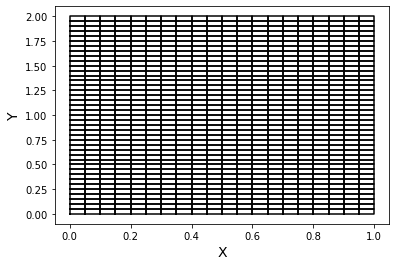

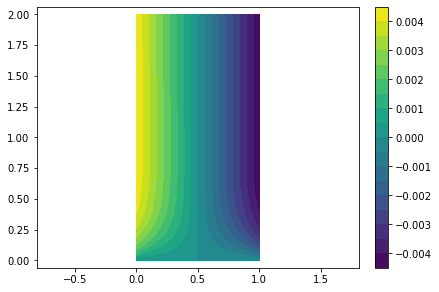

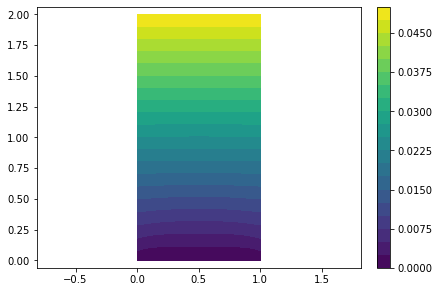

In [6]:
from FEToy.mesh.lagrange2dmesh import mesh2d
from FEToy.fe.shapefun import shape2d
from FEToy.fe.gaussrule import gausspoint2d
from FEToy.postprocess.PlotResult import Plot2D

####################
### pyhsical parameters
E=1.0e9
nu=0.3


mymesh=mesh2d(nx=20,ny=40,xmax=1.0,ymax=2.0,meshtype='quad4')
mymesh.createmesh()
mymesh.plotmesh()

gpoints=gausspoint2d(ngp=2)
gpoints.creategausspoint()

shp=shape2d(meshtype='quad4')
shp.update()

nDofs=mymesh.nodes*2 # 2 dofs for each point, ux+uy
K=np.zeros((nDofs,nDofs))
F=np.zeros(nDofs)

B=np.zeros((3,2))
Bt=np.zeros((2,3))
D=np.zeros((3,3))

D[0,0]=E/(1-nu**2)   ;D[0,1]=E*nu/(1-nu**2)
D[1,0]=E*nu/(1-nu**2);D[1,1]=E/(1-nu**2)
D[2,2]=0.5*E*(1-nu)/(1-nu**2)

# do element loop
for e in range(mymesh.elements):
    elconn=mymesh.elementconn[e,:]
    nodes=mymesh.nodecoords[elconn,:]
    for gp in range(gpoints.ngp2):
        xi =gpoints.gpcoords[gp,1]
        eta=gpoints.gpcoords[gp,2]
        w  =gpoints.gpcoords[gp,0]
        
        shp_val,shp_grad,j=shp.calc(xi,eta,nodes[:,0],nodes[:,1])
        JxW=j*w
        for i in range(mymesh.nodesperelement):
            B[0,0]=shp_grad[i,0]
            B[1,1]=shp_grad[i,1]
            B[2,0]=shp_grad[i,1]
            B[2,1]=shp_grad[i,0]
            iInd=elconn[i]
            for j in range(mymesh.nodesperelement):
                Bt[0,0]=shp_grad[j,0];Bt[0,2]=shp_grad[j,1]
                Bt[1,1]=shp_grad[j,1];Bt[1,2]=shp_grad[j,0]
                C=np.dot(Bt,np.dot(D,B)) # C=Bt*D*B==> 2x2 matrix
                jInd=elconn[j]
                # K_ux,ux
                K[2*iInd+0,2*jInd+0]+=C[0,0]*JxW
                # K_ux,uy
                K[2*iInd+0,2*jInd+1]+=C[0,1]*JxW
                # K_uy,ux
                K[2*iInd+1,2*jInd+0]+=C[1,0]*JxW
                # K_uy,uy
                K[2*iInd+1,2*jInd+1]+=C[1,1]*JxW
#########################################
Penalty=1.0e16

# fix ux=0 for bottom edge
iInd=mymesh.bcnodeids['bottom']*2
K[iInd,iInd]+=Penalty
F[iInd]=0.0

#print(mymesh.bcconn['left']) # for the boundary element on left edge or left side

# fix uy=0 for bottom edge
iInd=mymesh.bcnodeids['bottom']*2+1
K[iInd,iInd]+=Penalty
F[iInd]=0.0

# apply uy=0.05 for top edge
iInd=mymesh.bcnodeids['top']*2+1
K[iInd,iInd]+=Penalty
F[iInd]=0.05*Penalty

disp=np.linalg.solve(K,F)

Plot2D.Contour2D(mymesh,disp[0::2]) # ux
Plot2D.Contour2D(mymesh,disp[1::2]) # uy

from FEToy.postprocess.Result import ResultIO

result=ResultIO('mech2d')

result.save2csv(mesh=mymesh,solution=disp,varnamelist=['ux','uy'],step=0)

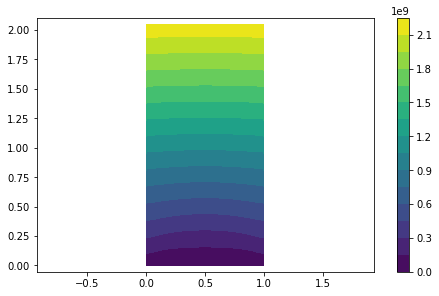

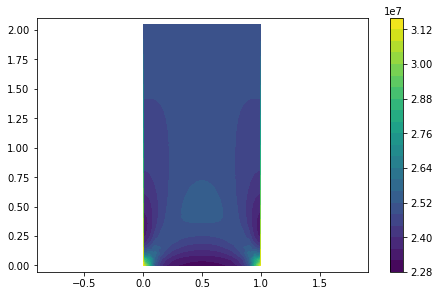

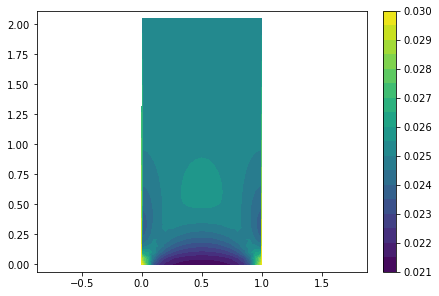

In [7]:
# Now we calculate the stress from gauss points to the nodal points
NodeCount=np.zeros(mymesh.nodes) # for nodal smooth
Stress_yy=np.zeros(mymesh.nodes)
Strain_yy=np.zeros(mymesh.nodes)
vonMises=np.zeros(mymesh.nodes)
devstress=np.zeros(3)
elu=np.zeros((mymesh.nodesperelement,2))
# do element loop
for e in range(mymesh.elements):
    elconn=mymesh.elementconn[e,:]
    x=mymesh.nodecoords[elconn,0]
    y=mymesh.nodecoords[elconn,1]
    for i in range(mymesh.nodesperelement):
        elu[i,0]=disp[2*elconn[i]]   # ux in first columne
        elu[i,1]=disp[2*elconn[i]+1] # uy in second col
    gpstress_yy=0.0
    gpstrain_yy=0.0
    gpvonMises=0.0
    for gp in range(gpoints.ngp2):
        xi =gpoints.gpcoords[gp,1]
        eta=gpoints.gpcoords[gp,2]
        w  =gpoints.gpcoords[gp,0]
        shp_val,shp_grad,j=shp.calc(xi,eta,x,y)
        stress_yy=0.0
        strain_yy=0.0
        vonstress=0.0
        for i in range(mymesh.nodesperelement):
            B[0,0]=shp_grad[i,0]
            B[1,1]=shp_grad[i,1]
            B[2,0]=shp_grad[i,1]
            B[2,1]=shp_grad[i,0]
            strain=np.dot(B,elu[i,:])
            stress=np.dot(D,strain)
            tr=stress[0]+stress[1] # trace of stress
            devstress[0]=stress[0]-(1.0/3.0)*tr*1.0
            devstress[1]=stress[1]-(1.0/3.0)*tr*1.0
            devstress[2]=stress[2]
            
            # vonMises=sqrt(1.5*s:s), devStress=stress-(1/3)*trace(stress)*I
            # s:s=dev_xx*dev_xx+dev_xy*dev_xy+dev_yy*dev_yy+dev_yx*dev_yx
            vonstress+=np.sqrt(1.5*(devstress[0]**2+devstress[1]**2+2*devstress[2]**2))
            stress_yy+=stress[1]
            strain_yy+=strain[1]
            
        # average all the gauss quantities
        gpstress_yy+=stress_yy/gpoints.ngp2
        gpstrain_yy+=strain_yy/gpoints.ngp2
        gpvonMises +=vonstress/gpoints.ngp2
    for i in range(mymesh.nodesperelement):
        # assemble
        iInd=elconn[i] # global index
        vonMises[iInd]+=gpvonMises
        Stress_yy[iInd]+=gpstress_yy
        Strain_yy[iInd]+=gpstrain_yy
            
        NodeCount[iInd]+=1.0
######################
for i in range(mymesh.nodes):
    vonMises[i]/=NodeCount[i]
    Stress_yy[i]/=NodeCount[i]
    Strain_yy[i]/=NodeCount[i]

#Plot2D.Contour2D(mymesh,vonMises)
Plot2D.Contour2DDeform(mymesh,disp,vonMises)
Plot2D.Contour2DDeform(mymesh,disp,Stress_yy)
Plot2D.Contour2DDeform(mymesh,disp,Strain_yy)